# llm from scratch

### Imports

In [1]:
import os

import tiktoken

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

### Multi-head attention

In [2]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, d_k, d_v, dropout,
            context_length, n_heads, qkv_bias=False):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_k
        self.wq = nn.Linear(d_model, n_heads * d_k, bias=qkv_bias)
        self.wk = nn.Linear(d_model, n_heads * d_k, bias=qkv_bias)
        self.wv = nn.Linear(d_model, n_heads * d_v, bias=qkv_bias)
        self.linear = nn.Linear(n_heads * d_v, d_model) 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', 
            torch.triu(torch.ones(context_length, context_length), 
            diagonal=1))    

    def forward(self, x):
        q = rearrange(self.wq(x), 'b t (h k) -> b h t k', h=self.n_heads)
        k = rearrange(self.wk(x), 'b t (h k) -> b h t k', h=self.n_heads)
        v = rearrange(self.wv(x), 'b t (h v) -> b h t v', h=self.n_heads)
        attn = torch.einsum('bhtk, bhsk -> bhts', q, k) / self.d_k**0.5
        mask_bool = self.mask.bool()[:x.size(1), :x.size(1)]
        attn = attn.masked_fill(mask_bool, -torch.inf)
        attn = F.softmax(attn, dim=3)
        attn = self.dropout(attn)
        out = torch.einsum('bhts, bhsv -> bhtv', attn, v)
        out = rearrange(out, 'b h t v -> b t (h v)')
        return self.linear(out) 

### Model config

In [3]:
CONFIG = {
    'vocab_size': 50257,
    'context_length': 256,
    'd_model': 768,
    'd_k': 64,
    'd_v': 64,
    'n_heads': 6,
    'n_blocks': 12,
    'dropout': 0.1,
    'qkv_bias': False
}

### Approximate GELU

In [4]:
class ApproxGELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(0.79788456 * (x + 0.044715 * x**3)))   

### Transformer block

In [5]:
class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            cfg['d_model'], cfg['d_k'], cfg['d_v'], 
            cfg['dropout'], cfg['context_length'], 
            cfg['n_heads'], cfg['qkv_bias'])
        self.ln1 = nn.LayerNorm(cfg['d_model'])
        self.mlp = nn.Sequential(
            nn.Linear(cfg['d_model'], 4 * cfg['d_model']),
            ApproxGELU(),
            nn.Linear(4 * cfg['d_model'], cfg['d_model'])
        )
        self.ln2 = nn.LayerNorm(cfg['d_model'])
        self.dropout = nn.Dropout(cfg['dropout'])

    def forward(self, x):
        shortcut = x
        x = self.dropout(self.attn(self.ln1(x)))
        x = x + shortcut

        shortcut = x
        x = self.dropout(self.mlp(self.ln2(x)))
        x = x + shortcut
        return x

### GPT-like model

In [6]:
class GPTVerdict(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['d_model'])
        self.position_embedding = nn.Embedding(cfg['context_length'], cfg['d_model'])
        self.dropout = nn.Dropout(cfg['dropout'])
        self.blocks = nn.ModuleList([
            TransformerBlock(cfg) for _ in range(cfg['n_blocks'])
        ])
        self.ln = nn.LayerNorm(cfg['d_model'])
        self.out_head = nn.Linear(cfg['d_model'], cfg['vocab_size'])

    def forward(self, x):
        b, t = x.size()
        x = self.token_embedding(x)
        x = x + self.position_embedding(torch.arange(t, device=x.device))   
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)
        logits = self.out_head(x)
        return logits

In [7]:
model = GPTVerdict(CONFIG)
model

GPTVerdict(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attn): MultiHeadAttention(
        (wq): Linear(in_features=768, out_features=384, bias=False)
        (wk): Linear(in_features=768, out_features=384, bias=False)
        (wv): Linear(in_features=768, out_features=384, bias=False)
        (linear): Linear(in_features=384, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): ApproxGELU()
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln): LayerNorm((768,), eps=1e-05, elementwise_

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 148,314,193 trainable parameters


### Functions to greedily generate text

In [9]:
def generate_idxs_greedily(model, idx_batch, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        cropped_idx_batch = idx_batch[:, -context_size:] # idx_batch is (batch, n_tokens)
        with torch.no_grad():
            logits = model(cropped_idx_batch)                   
        next_token_logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        next_token_probs = torch.softmax(next_token_logits, dim=-1) 
        next_token_idx = torch.argmax(next_token_probs, dim=-1, keepdim=True)  # (batch, 1)
        idx_batch = torch.cat((idx_batch, next_token_idx), dim=1)  # (batch, n_tokens+1)
    return idx_batch

def text_to_idxs(text, tokenizer):
    idxs = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return rearrange(torch.tensor(idxs), 'n -> 1 n')

def idxs_to_text(idxs, tokenizer):
    idxs = rearrange(idxs, '1 n -> n')
    return tokenizer.decode(idxs.tolist())

### Greedily generate text from untrained model

In [10]:
tokenizer = tiktoken.get_encoding("gpt2")

trial_start_context = "Hello, I am"

model.eval() 
out = generate_idxs_greedily(model=model,
                        idx_batch=text_to_idxs(trial_start_context, tokenizer),
                        max_new_tokens=10,
                        context_size=CONFIG["context_length"]
                        ) 

print(idxs_to_text(out, tokenizer))

Hello, I amSolutionortex manifestations Sal Carry liner counselors almondrocal streng


### Text data to train and evaluate model on

In [11]:
with open('data/the-verdict.txt', 'r', encoding='utf-8') as f:
    text_data = f.read()

print('total number of characters:', len(text_data))
print('total number of tokens:', len(tokenizer.encode(text_data)))

total number of characters: 20479
total number of tokens: 5145


### PyTorch dataset and dataloader

In [12]:
class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.token_ids = tokenizer.encode(text)
        self.input_ids = []
        self.target_ids = []

        for i in range(0, len(self.token_ids) - max_length, stride):
            input_chunk = self.token_ids[i:i+max_length]
            target_chunk = self.token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [13]:
def create_dataloader(text, batch_size=4, max_length=256,
                        stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(text, tokenizer, max_length, stride)   
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                shuffle=shuffle, drop_last=drop_last)
    return dataloader

### Trial dataloader and batch

In [14]:
trial_dataloader = create_dataloader(text_data, batch_size=4, max_length=256,
                                stride=1, shuffle=True, drop_last=True)

trial_batch = next(iter(trial_dataloader))
trial_batch     

[tensor([[  257, 17548,   286,  ..., 38378, 34537,   526],
         [  285,  4185,  1359,  ...,   612, 12703,  4964],
         [27034,    13,   402,  ...,  5223,   287,   281],
         [  683, 32081,   290,  ...,   616,  7363,     0]]),
 tensor([[17548,   286,   257,  ..., 34537,   526,   198],
         [ 4185,  1359,    26,  ..., 12703,  4964,    11],
         [   13,   402,   271,  ...,   287,   281,  8468],
         [32081,   290, 44852,  ...,  7363,     0,   198]])]

### Train and val datasets and dataloaders

In [15]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [16]:
train_dataloader = create_dataloader(
    train_data, batch_size=2, 
    max_length=CONFIG["context_length"],
    stride=CONFIG["context_length"],
    drop_last=True,
    shuffle=True
)

val_dataloader = create_dataloader(
    val_data, batch_size=2, 
    max_length=CONFIG["context_length"],
    stride=CONFIG["context_length"],
    drop_last=False,
    shuffle=False
) 

In [17]:
def evaluate_model(model, train_dataloader, val_dataloader, device):
    model.eval()
    total_train_loss = 0.
    total_val_loss = 0.
    with torch.no_grad():
        for input_batch, target_batch in train_dataloader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = rearrange(logits, 'b t v -> (b t) v')
            target_batch = rearrange(target_batch, 'b t -> (b t)')
            loss = F.cross_entropy(logits, target_batch)
            total_train_loss += loss.item()
        for input_batch, target_batch in val_dataloader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = rearrange(logits, 'b t v -> (b t) v')
            target_batch = rearrange(target_batch, 'b t -> (b t)')
            loss = F.cross_entropy(logits, target_batch)
            total_val_loss += loss.item()
    train_loss = total_train_loss / len(train_dataloader)
    val_loss = total_val_loss / len(val_dataloader)
    return train_loss, val_loss

In [18]:
def generate_and_print_sample(model, tokenizer, start_context, max_new_tokens):
    model.eval()
    idx_batch = text_to_idxs(start_context, tokenizer).to(device)
    with torch.no_grad():
        idx_batch = generate_idxs_greedily(
                model, idx_batch, max_new_tokens, 
                CONFIG["context_length"
        ])
        print(idxs_to_text(idx_batch, tokenizer).replace("\n", " "))  
    model.train() 

In [19]:
def train_model(model, train_dataloader, val_dataloader,
                optimizer, criterion, device, n_epochs,
                start_context, tokenizer, warmup_steps,
                peak_lr = 5e-4, initial_lr=3e-5, min_lr=1e-6):
    
    train_losses, val_losses, track_lrs = [], [], []
    global_step = -1

    total_training_steps = len(train_dataloader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            global_step += 1
            optimizer.zero_grad()
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = rearrange(logits, 'b t v -> (b t) v')
            target_batch = rearrange(target_batch, 'b t -> (b t)')

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment  
            else:
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            track_lrs.append(lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            loss = criterion(logits, target_batch)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
        train_loss, val_loss = evaluate_model(model, train_dataloader, val_dataloader, device) 
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        generate_and_print_sample(model, tokenizer=tokenizer, 
                        start_context=start_context, 
                        max_new_tokens=50)    

    return train_losses, val_losses, track_lrs

In [20]:
def plot_losses(epochs_seen, train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(5, 3))

    ax.plot(epochs_seen, train_losses, label="Training loss")
    ax.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right")
    fig.tight_layout()  
    plt.savefig("images/train-val-loss.png")

In [21]:
torch.manual_seed(42)
tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPTVerdict(CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 10
start_context = "Every effort moves you"

### Train model, or load saved weights if they exist

Epoch 1/10, Train Loss: 8.1234, Val Loss: 8.4114
Every effort moves you..,.....,...........,..,........,.........,.......
Epoch 2/10, Train Loss: 6.1444, Val Loss: 6.6445
Every effort moves you the, the, the, the, the, the, the, the, the, the the, the the, the, the, the, the, the, the, the, the, the, the, the, the, the,
Epoch 3/10, Train Loss: 5.7679, Val Loss: 6.5590
Every effort moves you, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the
Epoch 4/10, Train Loss: 4.8751, Val Loss: 6.3503
Every effort moves you the terr, and I had a was, and, and I had a a a a, and I had the fact, and it, and I had to the a the, and I had I had to me, and I had to the of
Epoch 5/10, Train Loss: 4.1370, Val Loss: 6.2585
Every effort moves you the fact, and I had been. Gisburn's the his pictures--as, I had been the the, I had the, I had been his, I had been his pictures--the of the, with a little--as the of
Epoch 6/10, Train Loss: 

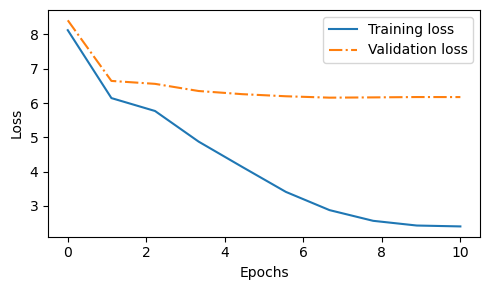

In [22]:
if os.path.exists('models/gpt_verdict.pth'):
    model.load_state_dict(torch.load('models/gpt_verdict.pth'))

else: 
    train_losses, val_losses, track_lrs = train_model(
        model, train_dataloader, val_dataloader, 
        optimizer, criterion, device, n_epochs,  
        start_context, tokenizer, warmup_steps=10
    )

    torch.save(model.state_dict(), 'models/gpt_verdict.pth')
    epochs_tensor = torch.linspace(0, n_epochs, len(train_losses))
    plot_losses(epochs_tensor, train_losses, val_losses)

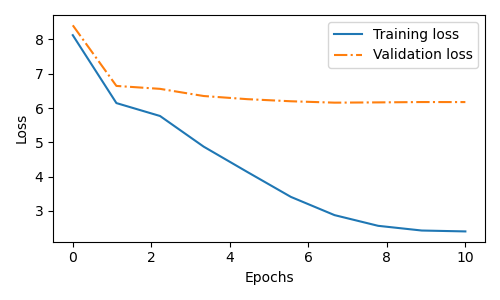

In [23]:
Image('images/train-val-loss.png')